# Running SWMM with Python
Example for the Gottesacker karst system
<br> Chloé Fandel 2019 (base model by Zhao Chen)

### TO-DO:
- update file paths
- check auto run outlets & warnings


### Setup

In [5]:
#Import published modules:
import pandas as pd
import numpy as np
import gdal
import geopandas as gpd
import pysheds
from pysheds.grid import Grid
import karstnet
from swmmtoolbox import swmmtoolbox as st
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pandas.plotting import register_matplotlib_converters

#Import local modules:
import swmmpy as sp
import mapping

#Plotting and error message settings:
pd.options.mode.chained_assignment = None  #this suppresses the pandas warning that happens when you overwrite things
%matplotlib inline
register_matplotlib_converters()           #this sets up matplotlib to handle date-time formats                            


In [28]:
#Set file paths:
dem_path     = 'DEMraster50_proj_251x200.tif'     #elevation raster - must have a coordinate system (can be set in ArcMap)
Qobs_path    = 'Qobs.csv'                         #observed spring discharge timeseries at QS,QE,QA  
swmm_template_path ='swmm_template.inp'           #template input file for SWMM, with placeholder strings to be replaced

#Units (default: Q in L/s):
u = 0.001   #set to 0.001 to convert to cubic meters per second

#Import spatial data:
dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres = mapping.importDEM(dem_path,show=False)    #import original DEM

#Import observed spring discharge timeseries data & reformat:
Qobs = pd.read_csv(Qobs_path, header=0, index_col=0, parse_dates=True, dtype=float, na_values='na')     #import spring discharge data
Qobs = Qobs*u                                                                                           #convert flow units

#Set up dataframe to calculate and store error stats:
names = ['obs','base','auto']      #list of names of models that will be run with SWMM 
stats = pd.DataFrame(columns=['QE','QA','QS','Sum'], index=names)   #df to store error stats

In [7]:
#Functions:

def calcErrors(Q, Qobs, name, stats):
    '''Calculates RMSE, NSC, and VE, using swmmpy built-in functions, for all three springs (QE,QA,QS) and stores them in one dataframe.
    Q: dataframe of simulated timeseries (returned by swmmpy.getQ())
    Qobs: dataframe of observed timeseries
    name: text string indicating name of model
    stats: dataframe with columns=['QE','QA','QS','Sum'] and index=[list of text strings indicating model names]'''
    
    stats.QE[name]  = {'RMSE':sp.RMSE(Qobs.QE, Q.QE), 'NSC':sp.NSC(Qobs.QE, Q.QE), 'VE':sp.VE(Qobs.QE,Q.QE)}
    stats.QA[name]  = {'RMSE':sp.RMSE(Qobs.QA, Q.QA), 'NSC':sp.NSC(Qobs.QA, Q.QA), 'VE':sp.VE(Qobs.QA,Q.QA)}
    stats.QS[name]  = {'RMSE':sp.RMSE(Qobs.QS, Q.QS), 'NSC':sp.NSC(Qobs.QS, Q.QS), 'VE':sp.VE(Qobs.QS,Q.QS)}
    stats.Sum[name] = {'RMSE':round(stats.QE[name]['RMSE'] + stats.QA[name]['RMSE'] + stats.QS[name]['RMSE'], 2),
                       'NSC': round(stats.QE[name]['NSC']  + stats.QA[name]['NSC']  + stats.QS[name]['NSC'],  2),
                       'VE':  round(stats.QE[name]['VE']   + stats.QA[name]['VE']   + stats.QS[name]['VE'],   2)}
    return stats

def plotQ(Q,c='k',lw=1,ls='-'):
    '''Plot discharge from all three springs
       Note: A figure with three subplot axes must be created first.
       Q: pandas dataframe with a datetime index and the columns QE,QA,QS containing discharge timeseries.
       c: string indicating the line style and color to plot with (ex: '--k')
       lw,ls: line width and line style (optional)'''
       
    ax[0].plot(Q.QE, c, linewidth=lw, linestyle=ls)
    ax[1].plot(Q.QA, c, linewidth=lw, linestyle=ls)
    ax[2].plot(Q.QS, c, linewidth=lw, linestyle=ls)

### Run a model from a pre-existing input file

In [8]:
#Define paths to SWMM in and out files:
#The input file must already exist, but the report and output files will be created
swmm_input_file    = 'gottesacker_base.inp'
swmm_report_file   = 'gottesacker_base.rpt'
swmm_output_file   = 'gottesacker_base.out'

In [9]:
#Run SWMM:
print('starting base model run')
sp.run(swmm_input_file, swmm_report_file, swmm_output_file)     #run SWMM as a subprocess

starting base model run


 o  Retrieving project data

... EPA-SWMM 5.1 (Build 5.1.13)





... EPA-SWMM completed in 43.00 seconds.



In [10]:
#Get run data:
Qbase = pd.DataFrame(index=Qobs.index)                  #create an empty dataframe with preset timesteps based on the observed discharge data
columns=['QE','QA','QS','Surface']                      #list of column names to use in df (one for each spring)
Qbase = sp.getQ(swmm_output_file, Qbase, columns)       #extract data from SWMM output file
Qbase = Qbase * u                                       #convert units
stats = calcErrors(Qbase, Qobs, 'base', stats)          #calculate and store error stats
stats                                                   #print error stats

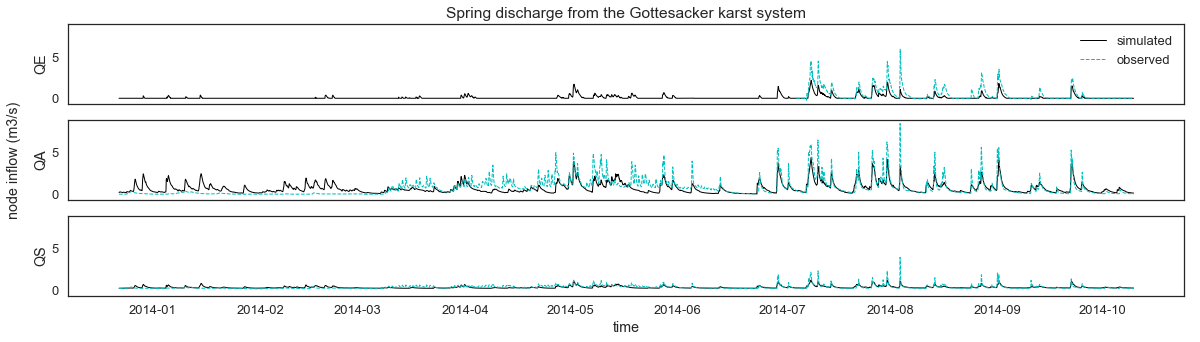

In [21]:
#Plot run data:

#Set up plot axes & labels:
f, ax = plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,5))   #set up three stacked subplots sharing axes (one for each spring)
f.add_subplot(111, frameon=False)                                     #add a big axis around the existing ones for formatting
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False) #hide the big axis
plt.xlabel('time')                                                                   #add labels to the big invisible axis
plt.ylabel('node inflow (m3/s)', labelpad=20)
plt.title('Spring discharge from the Gottesacker karst system')
ax[0].set_ylabel('QE')
ax[1].set_ylabel('QA')
ax[2].set_ylabel('QS')

#PLot data:
plotQ(Qbase)                #plot modelled discharge for all three springs
plotQ(Qobs, c='c', ls='--') #plot observed discharge

#Add legend:
legend = ['simulated','observed']
ax[0].legend(legend)   

### Run a model by inserting custom information into a template input file


In [29]:
#Define paths to SWMM in and out files (these will be created)
swmm_input_file    = 'gottesacker_auto.inp'       
swmm_report_file   = 'gottesacker_auto.rpt'
swmm_output_file   = 'gottesacker_auto.out'

#Define paths to node and link data (must already exist)
nodes_path   = 'nodes.txt'     #file listing nodes for model (X, Y, Z)
links_path   = 'links.txt'     #file listing pipes for model (fromNode, toNode)
spring_path  = 'springs.txt'   #file listing outfall nodes (X,Y,Z)

#Define paths to rainfall, baseflow, and manually-delineated subcatchments:
#(optional)
rainfall_path = 'base_rainfall.csv'                   #csv file of rainfall timeseries for original subcatchments
baseflow_path = 'base_baseflow.csv'                   #csv file of baseflow timeseries for original subcatchments
subcatchment_raster_path = 'subcatchments_raster.tif' #raster file for original precipitation subcatchments


In [30]:
#Assign parameters & create formatted dataframes for each section of the input file:

#Junctions, Outfalls, Conduits, Xsections, Coordinates:
nodes, links = sp.sks2swmm(nodes_path, links_path, spring_path, dim=3, simplify=False)      #import node, link, and spring data (outfalls will be assigned based on spring coordinates)
junctions = sp.set_junctions(nodes, maxdepth=0, initdepth=0, surdepth=200, aponded=0)       #create junctions df with parameter values given (can be single value or list of lengeth=# of junctions)
outfalls = sp.set_outfalls(nodes, outtype='FREE', stage='', tidegate='NO')                  
conduits = sp.set_conduits(links, nodes, manningN=0.01, inoffset='*', outoffset='*', initflow=0, maxflow=0)
xsections = sp.set_xsections(links, shape='FORCE_MAIN', g1=3.0, g2=1000.0, g3=0, g4=0, barrels=1, culvert='')
coordinates = sp.set_coordinates(nodes)

#Report:
rnodes = str(outfalls.Name.values)                      #get node name for all springs
rlinks = str(conduits.Name.iloc[-5:].values)            #get conduit names for last 5 conduits
rnodes = rnodes.replace('[','').replace(']','')         #strip brackets from string (there is probably a prettier way of doing this)
rlinks = rlinks.replace('[','').replace(']','')         #strip brackets from string (there is probably a prettier way of doing this)
report = sp.set_report(rnodes, rlinks)

#Subcatchments:
#automatically calculate subcatchments based on system nodes, using pysheds:
inlet_nodes = nodes[nodes.type=='junction']  #only use junction nodes as subcatchment inlets, not springs
catchs, areas = sp.import_subcatchments(dem_path, nodes=inlet_nodes, find_widths=False)    #calculate subcatchments from DEM (uses pysheds)
raingages = sp.set_raingages(catchs, raintype='VOLUME', tintvl='1:00', snowctch=1.0, datatype='TIMESERIES') #assign a raingage to each subcatchment
subcatchments = sp.set_subcatchments(nodes, catch=catchs, areas=areas, width='auto', pctimpv=100, slope=0.25, curblen=0, snowpack='', plot=False) #create subcatchment df and automatically calculate width
subareas = sp.set_subareas(catchs, nimperv=0.2, nperv=0.1, simperv=0.15, sperv=0.05, pctzero=100, routeto='IMPERVIOUS', pctrouted=100)
infiltration = sp.set_infiltration(catchs, maxrate=3, minrate=0.5, decay=4, drytime=7, maxinfil=0)
inflows = sp.set_inflows(nodes, catchs, par='FLOW', partype='FLOW', unitfactor=1.0, scalefactor=1.0, baseval='', basepattern='')

importing unsimplified network
assigning springs by adding spring nodes and linking to closest junction node
assigning subcatchments to nodes automatically using pysheds
pour point [ 587637.5 5245112.5] already snapped to! replacing with original node: [587747.5226, 5244963.63]
calculating width


In [31]:
#Timeseries:
#if timeseries of precipitation and baseflow for each subcatchment are already known, this is not necessary
#if timeseries are available for a different spatial distribution, 
#this section allows them to be calculated for the automatically-delineated subcatchments
print('recalculating timeseries')

#Import necessary data:
scBase, scaBase, *_ = sp.importDEM(subcatchment_raster_path)    #import raster of original subcatchment assignments (1-based indexing)
scaBase[np.isnan(scaBase)] = 0                                  #set nans to zero
scaBase[scaBase>20] = 0                                         #optional: remove unused subcatchments (in this case, the flysch zone)

baseRainfall = pd.read_csv(rainfall_path)                       #import rainfall data
baseBaseflow = pd.read_csv(baseflow_path)                       #import baseflow data
timestrings = baseRainfall[baseRainfall.catch==1].datetime.values   #get list of datetime strings from original data

#Recalculate based on new catchments:
rainfall, baseflow = sp.get_timeseries(baseRainfall, baseBaseflow, catchs, scaBase, timestrings)    #recalculate timeseries with new subcatchments

#Create SWMM-formatted dataframe: 
#if rainfall and baseflow timeseries are already available, skip above section and just provide them directly here
timeseries = sp.set_timeseries([rainfall, baseflow], ['Rainfall', 'Baseflow'], catchs, timestrings)     #create a formatted df to insert
print('done with timeseries')

recalculating timeseries
done with timeseries


In [32]:
#Prepare SWMM sections: 
#placeholders must list all the placeholder strings in the template input file
#data must list all the dataframes created above, to be inserted instead of the placeholders, in the same order as the placeholders
swmm_placeholders  = ['raingages', 'subcatchments', 'subareas', 'infiltration', 'junctions', 'outfalls', 'conduits',
                      'xsections', 'inflows', 'timeseries', 'report', 'coordinates'] 
swmm_data          = [ raingages,   subcatchments,   subareas,   infiltration,   junctions,   outfalls,   conduits,   
                       xsections,   inflows,   timeseries,   report,   coordinates]  #group data dataframes into a list

#Run SWMM:
print('writing input file for run in auto mode')
sp.write_input(swmm_input_file, swmm_placeholders, swmm_data, template_filename=swmm_template_path)     #write new input files from template
print('starting auto run')
sp.run(swmm_input_file, swmm_report_file, swmm_output_file)         #run SWMM as a subprocess
    

writing input file for run in auto mode
Int64Index([49], dtype='int64') raingages
Int64Index([89], dtype='int64') subcatchments
Int64Index([129], dtype='int64') subareas
Int64Index([169], dtype='int64') infiltration
Int64Index([209], dtype='int64') junctions
Int64Index([249], dtype='int64') outfalls
Int64Index([256], dtype='int64') conduits
Int64Index([298], dtype='int64') xsections
Int64Index([344], dtype='int64') inflows
Int64Index([384], dtype='int64') timeseries
Int64Index([570628], dtype='int64') report
Int64Index([570643], dtype='int64') coordinates
starting auto run


 o  Retrieving project data

... EPA-SWMM 5.1 (Build 5.1.13)





... EPA-SWMM completed in 2764.00 seconds. There are warnings.



In [33]:
#Get run data:
Qauto = pd.DataFrame(index=Qobs.index)              #create an empty dataframe with preset timesteps based on the observed discharge data
Qauto = sp.getQ(swmm_output_file, Qauto, columns)   #extract data from SWMM output file
Qauto = Qauto * u                                   #convert units
stats = calcErrors(Qauto, Qobs, 'auto', stats)      #calculate and store error stats
stats                                               #print error stats

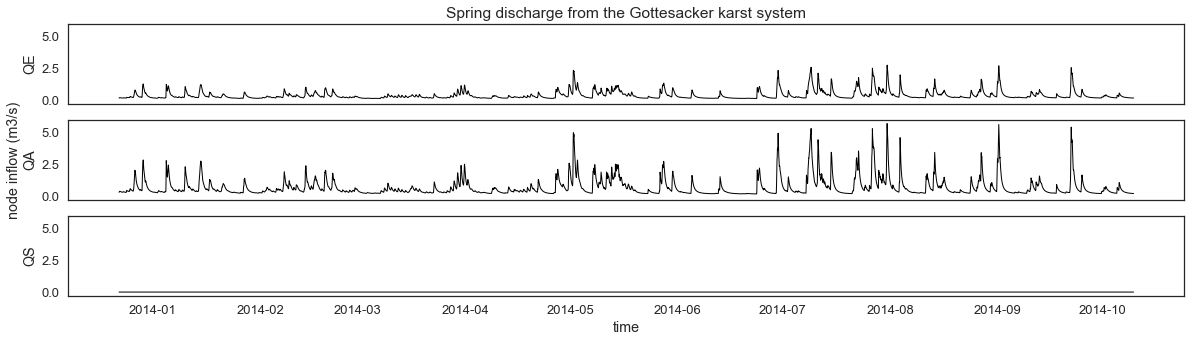

In [34]:
#Plot run data:
f, ax = plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,5))   #set up three stacked subplots sharing axes (one for each spring)
f.add_subplot(111, frameon=False)                                     #add a big axis around the existing ones for formatting
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False) #hide the big axis
plt.xlabel('time')                                                                   #add labels to the big invisible axis
plt.ylabel('node inflow (m3/s)', labelpad=20)
plt.title('Spring discharge from the Gottesacker karst system')
ax[0].set_ylabel('QE')
ax[1].set_ylabel('QA')
ax[2].set_ylabel('QS')
plotQ(Qauto)  #plot all three springs